In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import model_based_agent as mba 
import worm_env as we 
import ensemble_mod_env as eme

from improc import *
import utils as ut
import tab_agents as tab
from datetime import datetime 

In [3]:
frac_on = 1/2
collection_ep_time = 240 # in seconds. Must be a multiple of worm_ep_len
worm_ep_len = 120 # in seconds
init_df = None # with folder 


folder = './Data/HTDeb'+datetime.now().strftime('%d-%m-%H-%M')+'/'
if os.path.isdir(folder):
    os.rmdir(folder)
os.mkdir(folder)

# Initialize objects
dh = mba.DataHandler()
if init_df is not None:
    dh.load_df(init_df)
worm = we.ProcessedWorm(0,ep_len=worm_ep_len,ht_time=1e6) 

for ce in range(2):
# Collecting random data
#############################
    fname = folder+f'collect{ce}.pkl'
    mba.get_init_traj(fname, worm, int(collection_ep_time/worm_ep_len), rand_probs=[1-frac_on,frac_on])
    dh.add_dict_to_df([fname],reward_ahead=10,timestep_gap=1,prev_act_window=3,jump_limit=100)

KeyError: 'img'

In [73]:
obs_b = np.zeros((len(df)))
locs = np.zeros((len(df),2))
for i,obs in enumerate(df['obs_b']):
    obs_b[i] = obs
    locs[i,:] = df['loc'][i]

In [8]:
dh.df.columns

Index(['t', 'obs_b', 'obs_h', 'prev_actions', 'next_obs_b', 'next_obs_h',
       'reward', 'loc'],
      dtype='object')

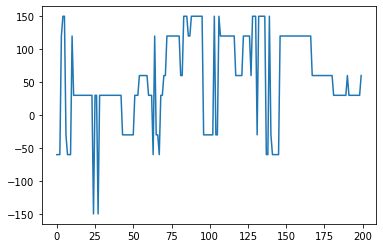

In [19]:
plt.plot(obs_b[:200])

In [32]:
mvt = np.sum(locs[:20,:]-locs[0,:],axis=0)

In [33]:
np.arctan2(mvt[1],mvt[0])*180/pi

-56.87514113685201

In [110]:
window=30
angs = []
for i in np.arange(window//2,len(locs)-window//2):
    mvt = np.sum(locs[i:i+window,:]-locs[i,:],axis=0)
    angs.append(np.arctan2(mvt[1],mvt[0])*180/pi)    
angs = np.hstack([np.zeros(window//2)+angs[0],angs,np.zeros(window//2)+angs[-1]])

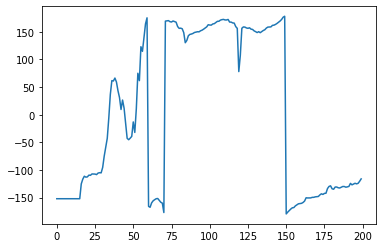

In [111]:
plt.plot(angs[:200])

In [114]:
ob_fix = ut.wrap_correct(obs_b.copy(),ref=angs)
for i,ang in enumerate(angs):
    if abs(ob_fix[i]-ang) > 90:
        ob_fix[i] += 180
ob_fix = ut.wrap_correct(ob_fix)

In [130]:
ad = angs-ob_fix
ad[ad>180] -= 360
ad[ad<-180] += 360

od = angs-obs_b
od[od>180] -= 360
od[od<-180] += 360

In [134]:
ad[abs(ad)-abs(od)>0]

array([], dtype=float64)

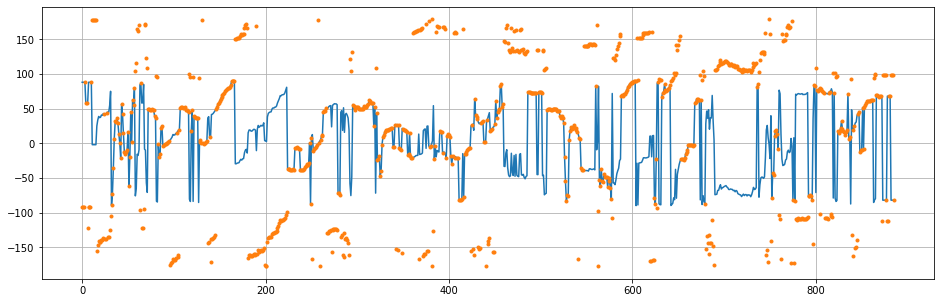

In [131]:
tmp=350
plt.figure(figsize=(16,5))
plt.plot(ad)
plt.plot(od,'.')
plt.grid();

In [137]:
x = np.array([1,0])
np.flip(x)

array([0, 1])

In [146]:
dh.df['test'] = np.zeros(len(dh.df))+1

In [147]:
dh.df

,t,obs_b,obs_h,prev_actions,next_obs_b,next_obs_h,reward,loc,test
0,0.938,60,-30,0,60,30,0.222222,"[772.6538461538462, 1071.2307692307693]",1.0
1,1.125,60,30,1,60,30,0.501603,"[773.04, 1071.34]",1.0
2,1.297,60,30,2,60,30,0.819167,"[774.313725490196, 1071.313725490196]",1.0
3,1.485,60,30,3,60,0,1.226769,"[774.4285714285714, 1071.3265306122448]",1.0
4,1.688,60,0,2,60,-30,1.369084,"[775.7647058823529, 1071.5098039215686]",1.0
...,...,...,...,...,...,...,...,...,...
12764,117.782,150,0,1,-150,-60,4.692308,"[485.92857142857144, 557.7142857142857]",1.0
12765,117.954,-150,-60,0,-150,-90,4.587558,"[486.21428571428567, 557.6428571428571]",1.0
12766,118.157,-150,-90,1,-150,-90,4.817972,"[487.68421052631584, 557.3157894736842]",1.0
12767,118.344,-150,-90,2,-150,-90,3.409539,"[489.25, 556.7857142857143]",1.0


In [2]:
def correct_ht(df,window=30):
    # Takes a dataframe and fixes HT switches. 
    # df must have keys ['t', 'obs_b', 'angs', 'prev_actions', 'reward', 'loc', 'target']
    # Returns a dataframe with 'obs_h', 'next_obs_b', and 'next_obs_h'
    
    # Make a location array
    locs = np.zeros((len(df),2))
    obs_b = np.zeros((len(df)))
    for i,loc in enumerate(df['loc']):
        locs[i,:] = loc
        obs_b[i] = df['obs_b'][i]
        
    # Use location array to make direction of travel
    angs = []
    for i in np.arange(window//2,len(locs)-window//2):
        mvt = np.sum(locs[i-window//2:i+window//2,:]-locs[i-window//2,:],axis=0)
        angs.append(np.arctan2(-mvt[1],mvt[0])*180/pi - df['target'][i])   # flip y as usual 
        
    angs = np.hstack([np.zeros(window//2)+angs[0],angs,np.zeros(window//2)+angs[-1]])
    
    # Fixes observation by 180 deg. If it has to switch something, also switches angle.
    ob_fix = ut.wrap_correct(obs_b.copy(),ref=angs)
    for i,ang in enumerate(angs):
        if abs(ob_fix[i]-ang) > 90:
            ob_fix[i] += 180
            df['angs'][i] = np.flip(df['angs'][i])
    ob_fix = ut.wrap_correct(ob_fix)
    
    # Edits dataframe to reflect changes
    df['obs_b'] = ob_fix
    df.insert(len(df.columns),'obs_h',np.zeros((len(df))))
    df.insert(len(df.columns),'next_obs_b',np.zeros((len(df))))
    df.insert(len(df.columns),'next_obs_h',np.zeros((len(df))))
    for i in range(len(df)):
        df['obs_h'][i] = df['angs'][i][0]
    for i in range(len(df)-1):
        df['next_obs_b'][i] = df['obs_b'][i+1]
        df['next_obs_h'][i] = df['obs_h'][i+1]
    df['next_obs_b'][len(df)-1] = df['obs_b'][len(df)-1]
    df['next_obs_h'][len(df)-1] = df['obs_h'][len(df)-1]
    
    return angs,df
        

In [5]:
def make_df(fname, 
    old_frame=None, 
    reward_ahead=10, 
    timestep_gap=1, 
    prev_act_window=3, 
    jump_limit=100,
    ):

    '''
    Takes a file and turns it into a trajectory dataframe.
    Can add to old data.
    Inputs:
                old_frame: old df
             reward_ahead: how many steps ahead to sum reward, for each table entry
             timestep_gap: how data are sampled (e.g. =5 means only every fifth datapoint is kept)
          prev_act_window: how many steps to look back to make sure all actions were 'on' or 'off'
               jump_limit: data are processed to remove faulty points where worm loc has jumped really far.
                           This is the maximum jump distance allowed before points are tossed.
                     disc: discretization of angles

    Output:
        dataframe object with keys:
            't', 'obs_b', 'angs', 'prev_actions', 'reward', 'loc'
    '''
    def add_ind_to_df(traj,df,i, reward_ahead, prev_act_window):
        # Assumes data for angle observations go from -1 to 1. 
        # This was because of use w/ normalized box wrapper with actual worm env
        ANG_BOUND = 180
        return df.append({
            't'           : traj['t'][i],
            'obs_b'       : int(traj['obs'][i][0]*ANG_BOUND),
            'angs'        : [relative_angle((traj['angs'][i][j]).astype(int),
                                            int(traj['obs'][i][0]*ANG_BOUND)) for j in range(2)],
            'prev_actions': sum(traj['action'][i-prev_act_window:i]), # Note does not include current action
            'reward'      : sum(traj['reward'][i:i+reward_ahead]),
            'loc'         : traj['loc'][i],
            'target'      : traj['target'][i],
        }, ignore_index=True)

    if old_frame is None:
        df = pd.DataFrame(columns = ['t', 'obs_b', 'angs', 'prev_actions', 'reward', 'loc'])
    else:
        df = old_frame

    # Loop through and remove problem points.
    newf = True
    with open(fname, 'rb') as f:
        traj = pickle.load(f)

    for i in np.arange(prev_act_window,len(traj['t'])-reward_ahead,timestep_gap):
        # For every timestep, check if the jump is reasonable and add to dataframe.
        if newf:
            if sum(traj['loc'][i])!=0:
                df = add_ind_to_df(traj,df,i,reward_ahead,prev_act_window)
                newf = False
        elif np.sqrt(np.sum(np.square(df['loc'].iloc[-1]-traj['loc'][i]))) < jump_limit:
            df = add_ind_to_df(traj,df,i,reward_ahead,prev_act_window)

    return df

In [6]:
df = make_df('./Data/HTDeb18-01-19-53/collect0.pkl')

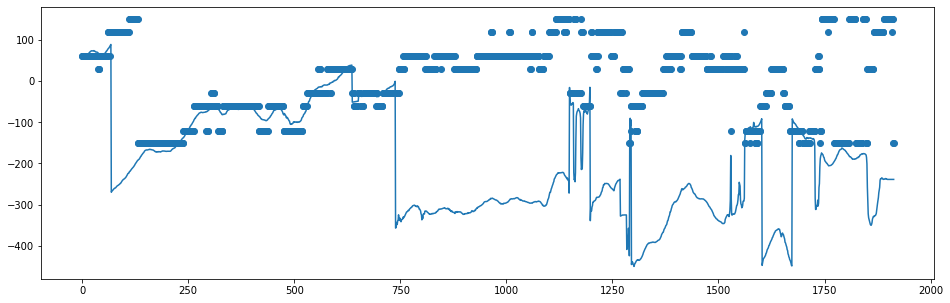

In [13]:
plt.figure(figsize=(16,5))
plt.scatter(np.arange(len(df)),df['obs_b'].to_numpy())
plt.plot(angs)

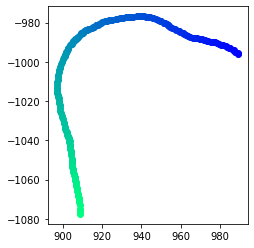

In [83]:
NPOINTS = 200
start = 0
fig,ax = plt.subplots(1)

ax.set_prop_cycle('color',plt.cm.winter(np.linspace(0,1,NPOINTS)))
for i in np.arange(start,start+NPOINTS-1):
    img = ax.scatter(locs[i,0],-locs[i,1])
    ax.set_aspect('equal','box')

In [12]:
angs,df = correct_ht(df)

<ipython-input-2-ba9a27820486>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['angs'][i] = np.flip(df['angs'][i])
<ipython-input-2-ba9a27820486>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['obs_h'][i] = df['angs'][i][0]
<ipython-input-2-ba9a27820486>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['next_obs_b'][i] = df['obs_b'][i+1]
<ipython-input-2-ba9a27820486>:38: SettingWithCopyWarning: 
A value is trying to be 

In [9]:
with open('./Data/HTDeb18-01-19-53/collect0.pkl','rb') as f:
    traj = pickle.load(f)

In [154]:
traj.keys()

dict_keys(['loc', 't', 'endpts', 'obs', 'reward', 'target', 'action'])

In [11]:
traj['endpts'][15:18]

[array([[969, 988],
        [989, 994]]),
 array([[968, 986],
        [988, 994]]),
 array([[966, 985],
        [989, 994]])]

In [7]:
df[15:50]

,t,obs_b,angs,prev_actions,reward,loc,target
15,3.797,60,"[150, 300]",3,2.189236,"[976.1612903225806, 989.8387096774194]",90.0
16,3.985,60,"[180, 300]",2,2.060932,"[975.1774193548387, 989.6935483870968]",90.0
17,4.188,60,"[180, 300]",1,1.788786,"[974.0, 989.530303030303]",90.0
18,4.375,60,"[120, 300]",0,1.899534,"[973.3230769230769, 989.2153846153847]",90.0
19,4.563,60,"[90, 300]",0,1.582051,"[972.3484848484849, 988.9090909090909]",90.0
20,4.766,60,"[120, 330]",0,1.727273,"[971.8307692307692, 988.7076923076924]",90.0
21,4.953,60,"[90, 0]",0,1.768298,"[970.875, 988.34375]",90.0
22,5.156,60,"[120, 0]",0,1.935299,"[970.063492063492, 988.1904761904761]",90.0
23,5.360,60,"[180, 0]",0,2.359490,"[969.7543859649123, 988.1929824561404]",90.0
24,5.547,60,"[180, 0]",0,2.864215,"[968.375, 987.921875]",90.0


In [7]:
df[15:50]

,t,obs_b,angs,prev_actions,reward,loc,target
15,3.797,60,"[90, -120]",3,2.189236,"[976.1612903225806, 989.8387096774194]",90.0
16,3.985,60,"[120, -120]",2,2.060932,"[975.1774193548387, 989.6935483870968]",90.0
17,4.188,60,"[120, -120]",1,1.788786,"[974.0, 989.530303030303]",90.0
18,4.375,60,"[60, -120]",0,1.899534,"[973.3230769230769, 989.2153846153847]",90.0
19,4.563,60,"[30, -120]",0,1.582051,"[972.3484848484849, 988.9090909090909]",90.0
20,4.766,60,"[60, -90]",0,1.727273,"[971.8307692307692, 988.7076923076924]",90.0
21,4.953,60,"[30, -60]",0,1.768298,"[970.875, 988.34375]",90.0
22,5.156,60,"[60, -60]",0,1.935299,"[970.063492063492, 988.1904761904761]",90.0
23,5.360,60,"[120, -60]",0,2.359490,"[969.7543859649123, 988.1929824561404]",90.0
24,5.547,60,"[120, -60]",0,2.864215,"[968.375, 987.921875]",90.0


In [72]:
locs = np.zeros()

,t,obs_b,angs,prev_actions,reward,loc,obs_h,next_obs_b,next_obs_h
15,3.797,-120.0,"[300, 150]",3,2.189236,"[976.1612903225806, 989.8387096774194]",300.0,-120.0,300.0
16,3.985,-120.0,"[300, 180]",2,2.060932,"[975.1774193548387, 989.6935483870968]",300.0,-120.0,300.0
17,4.188,-120.0,"[300, 180]",1,1.788786,"[974.0, 989.530303030303]",300.0,-120.0,300.0
18,4.375,-120.0,"[300, 120]",0,1.899534,"[973.3230769230769, 989.2153846153847]",300.0,-120.0,300.0
19,4.563,-120.0,"[300, 90]",0,1.582051,"[972.3484848484849, 988.9090909090909]",300.0,-120.0,330.0
20,4.766,-120.0,"[330, 120]",0,1.727273,"[971.8307692307692, 988.7076923076924]",330.0,-120.0,0.0
21,4.953,-120.0,"[0, 90]",0,1.768298,"[970.875, 988.34375]",0.0,-120.0,0.0
22,5.156,-120.0,"[0, 120]",0,1.935299,"[970.063492063492, 988.1904761904761]",0.0,-120.0,0.0
23,5.360,-120.0,"[0, 180]",0,2.359490,"[969.7543859649123, 988.1929824561404]",0.0,-120.0,0.0
24,5.547,-120.0,"[0, 180]",0,2.864215,"[968.375, 987.921875]",0.0,-120.0,0.0


In [96]:
dh = mba.DataHandler()
dh.load_df('test.pkl')

In [97]:
dh.df

,t,obs_b,angs,prev_actions,reward,loc,obs_h,next_obs_b,next_obs_h
0,0.953,-120.0,"[0, 120]",0,5.110318,"[989.421052631579, 996.0701754385964]",0.0,-120.0,0.0
1,1.141,-120.0,"[0, 120]",1,4.697294,"[989.09375, 995.65625]",0.0,-120.0,0.0
2,1.313,-120.0,"[0, 120]",2,4.748558,"[987.8524590163935, 994.8852459016393]",0.0,-120.0,330.0
3,1.500,-120.0,"[330, 90]",3,4.316015,"[986.9032258064516, 994.1612903225807]",330.0,-120.0,300.0
4,1.672,-120.0,"[300, 120]",2,4.087761,"[986.6666666666666, 993.984126984127]",300.0,-120.0,300.0
...,...,...,...,...,...,...,...,...,...
1909,119.594,-30.0,"[180, 90]",2,-5.068649,"[979.5571428571428, 1185.9]",180.0,-30.0,180.0
1910,119.781,-30.0,"[180, 300]",3,-6.475125,"[980.25, 1185.5]",180.0,-30.0,210.0
1911,119.969,-30.0,"[210, 300]",2,-7.104744,"[981.1891891891892, 1185.1486486486488]",210.0,30.0,300.0
1912,120.156,30.0,"[300, 210]",1,-6.973526,"[981.7530864197531, 1185.2592592592594]",300.0,30.0,300.0


In [92]:
df.to_pickle('test.pkl')
df_params = {
            'reward_ahead': 10,
            'timestep_gap': 1,
            'prev_act_window': 3,
            'jump_limit': 100,
        }
with open('test_params.pkl','wb') as f:
    pickle.dump(df_params, f)

In [111]:
mset = eme.ModelSet(1,frac=1)
mset.make_models(dh,sm_pars={'lambda':.1,'iters':10})

On model 0
Penalty 0.6887373933500809


In [112]:
mod = mset.models[0]

In [113]:
def plot_mods(models,vmin=None,vmax=None):
    fig,ax = plt.subplots(len(models),7)
    fig.set_size_inches((15,2*len(models)))
    for m,mod in enumerate(models):
        for i,(key,item) in enumerate(mod.items()):
            if i<4:
                img = ax[m,i].imshow(item[:,:,0],vmin=-180,vmax=180)
            else:
                img = ax[m,i].imshow(item[:,:,0],vmin=vmin,vmax=vmax)
            fig.colorbar(img,ax=ax[m,i])
            ax[m,i].axis('off')
            if m==0:
                ax[m,i].set_title(f'{len(models)} models: {key}')
        ax[m,6].imshow(np.sign(mod['reward_on']-mod['reward_off'])[:,:,0],vmin=-1,vmax=1)

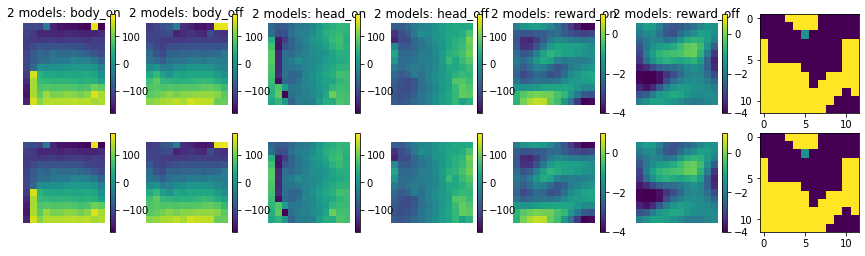

In [117]:
mods_plt = [mod,mod]
plot_mods(mods_plt,vmin=-4,vmax=1)

In [110]:
fold = './Data/HTDeb18-01-20-45/collect'
dh = mba.DataHandler()
dh.add_dict_to_df([fold+str(i)+'.pkl' for i in range(2)],reward_ahead=10,timestep_gap=1,prev_act_window=3,jump_limit=100)